### Load data

In [2]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
df = spark.table('df_model_final_all')
df.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|device_type|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|80percent_finished_song_count_last_1|80percent_finished_song_count_last_3|80percent_finished_song_count_last_7|80percent_finished_song_count_last_14|80percent_finished_song_count_last_30|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+
104615847| 0| 0| 1| 1| 1| 3| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2| 0| 0| 2| 513| 513| 513| 513| 513| 0| 0| 0| 0| 0|
 10498817| 1| 0| 0| 0| 0| 8| 0| 0| 0| 0| 1| 0| 0| 0| 0| 1| 26| 29| 29| 2| 662| 662| 662| 662| 662| 3| 3| 3| 3| 3|
107762990| 0| 0| 5| 9| 69| 259| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1| 2| 0| 15| 2| 185368| 185368| 185368| 185368| 185368| 100| 100| 100| 100| 100|
 11561198| 0| 0| 0| 0| 353| 360| 0| 0| 0| 4| 4| 0| 0| 0| 18| 18| 7| 8| 8| 2| 6394| 6394| 6394| 6394| 6394| 18| 18| 18| 18| 18|
116543180| 1| 0| 0| 0| 4| 47| 0| 0| 0| 0| 0| 0| 0| 0| 1| 4| 7| 0| 7| 2| 4166| 4166| 4166| 4166| 4166| 19| 19| 19| 19| 19|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+
only showing top 5 rows

In [4]:
df

Out[ 3 ]: DataFrame[uid: string, label: int, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint, days_from_last_P: int, days_from_last_D: int, days_from_last_S: int, device_type: int, play_time_last_1: bigint, play_time_last_3: bigint, play_time_last_7: bigint, play_time_last_14: bigint, play_time_last_30: bigint, 80percent_finished_song_count_last_1: bigint, 80percent_finished_song_count_last_3: bigint, 80percent_finished_song_count_last_7: bigint, 80percent_finished_song_count_last_14: bigint, 80percent_finished_song_count_last_30: bigint]

### Prepare training data

In [6]:
type(df.columns)

Out[ 4 ]: list

In [7]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

Out[ 5 ]: 
['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'days_from_last_P',
 'days_from_last_D',
 'days_from_last_S',
 'play_time_last_1',
 'play_time_last_3',
 'play_time_last_7',
 'play_time_last_14',
 'play_time_last_30',
 '80percent_finished_song_count_last_1',
 '80percent_finished_song_count_last_3',
 '80percent_finished_song_count_last_7',
 '80percent_finished_song_count_last_14',
 '80percent_finished_song_count_last_30']

In [8]:
# training data
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df)

#For VectorAssembler, refer to https://spark.apache.org/docs/latest/ml-features.html#vectorassembler

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

In [9]:
selected_features

Out[ 7 ]: 
['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'days_from_last_P',
 'days_from_last_D',
 'days_from_last_S',
 'play_time_last_1',
 'play_time_last_3',
 'play_time_last_7',
 'play_time_last_14',
 'play_time_last_30',
 '80percent_finished_song_count_last_1',
 '80percent_finished_song_count_last_3',
 '80percent_finished_song_count_last_7',
 '80percent_finished_song_count_last_14',
 '80percent_finished_song_count_last_30']

In [10]:
data.select('features').show(5)
#What does those notations mean?

+--------------------+
 features|
+--------------------+
(28,[1,2,3,4,15,1...|
(28,[4,9,14,15,16...|
(28,[1,2,3,4,14,1...|
[0.0,0.0,0.0,353....|
(28,[3,4,13,14,15...|
+--------------------+
only showing top 5 rows

In [11]:
#Convert to pandas for better understanding
a=data.select('features').toPandas()

In [12]:
#seems alright now
a

Out[ 10 ]: 
 features
0 (0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, ...
1 (0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, ...
2 (0.0, 5.0, 9.0, 69.0, 259.0, 0.0, 0.0, 0.0, 0....
3 [0.0, 0.0, 0.0, 353.0, 360.0, 0.0, 0.0, 0.0, 4...
4 (0.0, 0.0, 0.0, 4.0, 47.0, 0.0, 0.0, 0.0, 0.0,...
5 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
6 [10.0, 252.0, 560.0, 917.0, 1032.0, 0.0, 3.0, ...
7 (0.0, 0.0, 0.0, 27.0, 43.0, 0.0, 0.0, 0.0, 0.0...
8 (0.0, 0.0, 0.0, 0.0, 152.0, 0.0, 0.0, 0.0, 0.0...
9 (0.0, 0.0, 0.0, 38.0, 193.0, 0.0, 0.0, 0.0, 0....
10 (0.0, 0.0, 0.0, 0.0, 72.0, 0.0, 0.0, 0.0, 0.0,...
11 (0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0,...
12 (0.0, 0.0, 0.0, 0.0, 507.0, 0.0, 0.0, 0.0, 0.0...
13 (0.0, 0.0, 0.0, 1.0, 253.0, 0.0, 0.0, 0.0, 0.0...
14 [27.0, 219.0, 713.0, 1325.0, 2870.0, 0.0, 3.0,...
15 (0.0, 0.0, 0.0, 58.0, 404.0, 0.0, 0.0, 0.0, 0....
16 [19.0, 36.0, 102.0, 207.0, 487.0, 0.0, 0.0, 0....
17 (0.0, 0.0, 0.0, 0.0, 316.0, 0.0, 0.0, 0.0, 0.0...
18 [0.0, 33.0, 182.0, 559.0, 755.0, 0.0, 0.0, 3.0...
19 (0.0, 0.0, 0.0, 46.0, 816.0, 0.0, 0.0, 0.0, 0....
20 (0.0, 0.0, 0.0, 1.0, 37.0, 0.0, 0.0, 0.0, 0.0,...
21 (0.0, 0.0, 0.0, 0.0, 31.0, 0.0, 0.0, 0.0, 0.0,...
22 (0.0, 0.0, 0.0, 1.0, 14.0, 0.0, 0.0, 0.0, 0.0,...
23 (0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
24 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
25 [6.0, 62.0, 347.0, 520.0, 1266.0, 0.0, 46.0, 5...
26 [31.0, 231.0, 908.0, 1081.0, 1426.0, 0.0, 0.0,...
27 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
28 [45.0, 166.0, 212.0, 222.0, 404.0, 0.0, 7.0, 9...
29 (0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
... ...
664000 (0.0, 0.0, 0.0, 0.0, 90.0, 0.0, 0.0, 0.0, 0.0,...
664001 (0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
664002 [27.0, 60.0, 75.0, 93.0, 117.0, 0.0, 0.0, 0.0,...
664003 [11.0, 31.0, 70.0, 151.0, 234.0, 0.0, 0.0, 0.0...
664004 (0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...
664005 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664006 [7.0, 7.0, 9.0, 74.0, 333.0, 0.0, 0.0, 0.0, 0....
664007 (0.0, 0.0, 0.0, 8.0, 9.0, 0.0, 0.0, 0.0, 0.0, ...
664008 (0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, ...
664009 (0.0, 0.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0,...
664010 [0.0, 0.0, 26.0, 37.0, 59.0, 0.0, 0.0, 1.0, 3....
664011 [0.0, 17.0, 17.0, 17.0, 19.0, 0.0, 0.0, 0.0, 0...
664012 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
664013 [0.0, 7.0, 29.0, 209.0, 322.0, 0.0, 0.0, 0.0, ...
664014 (0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0,...
664015 (0.0, 8.0, 38.0, 38.0, 139.0, 0.0, 0.0, 0.0, 0...
664016 (0.0, 19.0, 111.0, 238.0, 291.0, 0.0, 0.0, 0.0...
664017 (0.0, 0.0, 0.0, 0.0, 30.0, 0.0, 0.0, 0.0, 0.0,...
664018 [14.0, 42.0, 155.0, 285.0, 311.0, 0.0, 0.0, 1....
664019 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664020 (0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0,...
664021 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
664022 (0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, ...
664023 (0.0, 0.0, 0.0, 0.0, 281.0, 0.0, 0.0, 0.0, 0.0...
664024 [0.0, 0.0, 14.0, 94.0, 553.0, 0.0, 0.0, 2.0, 2...
664025 (0.0, 0.0, 0.0, 17.0, 17.0, 0.0, 0.0, 0.0, 0.0...
664026 [72.0, 110.0, 180.0, 342.0, 602.0, 0.0, 0.0, 0...
664027 (0.0, 0.0, 0.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, ...
664028 (0.0, 0.0, 0.0, 315.0, 439.0, 0.0, 0.0, 0.0, 0...
664029 (0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...

[664030 rows x 1 columns]

In [13]:
#however the notation in pyspark dataframe is different
data.select('features').head(5)

Out[ 11 ]: 
[Row(features=SparseVector(28, {1: 1.0, 2: 1.0, 3: 1.0, 4: 3.0, 15: 2.0, 18: 513.0, 19: 513.0, 20: 513.0, 21: 513.0, 22: 513.0})),
 Row(features=SparseVector(28, {4: 8.0, 9: 1.0, 14: 1.0, 15: 26.0, 16: 29.0, 17: 29.0, 18: 662.0, 19: 662.0, 20: 662.0, 21: 662.0, 22: 662.0, 23: 3.0, 24: 3.0, 25: 3.0, 26: 3.0, 27: 3.0})),
 Row(features=SparseVector(28, {1: 5.0, 2: 9.0, 3: 69.0, 4: 259.0, 14: 1.0, 15: 2.0, 17: 15.0, 18: 185368.0, 19: 185368.0, 20: 185368.0, 21: 185368.0, 22: 185368.0, 23: 100.0, 24: 100.0, 25: 100.0, 26: 100.0, 27: 100.0})),
 Row(features=DenseVector([0.0, 0.0, 0.0, 353.0, 360.0, 0.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, 0.0, 18.0, 18.0, 7.0, 8.0, 8.0, 6394.0, 6394.0, 6394.0, 6394.0, 6394.0, 18.0, 18.0, 18.0, 18.0, 18.0])),
 Row(features=SparseVector(28, {3: 4.0, 4: 47.0, 13: 1.0, 14: 4.0, 15: 7.0, 17: 7.0, 18: 4166.0, 19: 4166.0, 20: 4166.0, 21: 4166.0, 22: 4166.0, 23: 19.0, 24: 19.0, 25: 19.0, 26: 19.0, 27: 19.0}))]

In [14]:
data.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|device_type|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|80percent_finished_song_count_last_1|80percent_finished_song_count_last_3|80percent_finished_song_count_last_7|80percent_finished_song_count_last_14|80percent_finished_song_count_last_30| features|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+
104615847| 0| 0| 1| 1| 1| 3| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 2| 0| 0| 2| 513| 513| 513| 513| 513| 0| 0| 0| 0| 0|(28,[1,2,3,4,15,1...|
 10498817| 1| 0| 0| 0| 0| 8| 0| 0| 0| 0| 1| 0| 0| 0| 0| 1| 26| 29| 29| 2| 662| 662| 662| 662| 662| 3| 3| 3| 3| 3|(28,[4,9,14,15,16...|
107762990| 0| 0| 5| 9| 69| 259| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1| 2| 0| 15| 2| 185368| 185368| 185368| 185368| 185368| 100| 100| 100| 100| 100|(28,[1,2,3,4,14,1...|
 11561198| 0| 0| 0| 0| 353| 360| 0| 0| 0| 4| 4| 0| 0| 0| 18| 18| 7| 8| 8| 2| 6394| 6394| 6394| 6394| 6394| 18| 18| 18| 18| 18|[0.0,0.0,0.0,353....|
116543180| 1| 0| 0| 0| 4| 47| 0| 0| 0| 0| 0| 0| 0| 0| 1| 4| 7| 0| 7| 2| 4166| 4166| 4166| 4166| 4166| 19| 19| 19| 19| 19|(28,[3,4,13,14,15...|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+
only showing top 5 rows

### Fit logistic regression

In [16]:
#Documentation: http://spark.apache.org/docs/2.2.2/api/java/org/apache/spark/ml/classification/LogisticRegression.html
ml = LogisticRegression(maxIter=3, regParam=0.01)
#set max iteration and regularization parameter
model = ml.fit(train)

In [17]:
type(model)

Out[ 14 ]: pyspark.ml.classification.LogisticRegressionModel

### Predict and Evaluate performance

In [19]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.39817081632562...| 1.0| 0|(28,[4,9,15,16,18...|
[0.20508185977838...| 1.0| 1|(28,[14,17],[1.0,...|
[0.13917846912312...| 1.0| 1|(28,[4,15,18,19,2...|
[0.06033283133204...| 1.0| 1|(28,[4,9,14,15,16...|
[0.06407053231891...| 1.0| 1|(28,[4,9,14,15,16...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.30318534173150...| 1.0| 0|(28,[1,2,3,4,15,1...|
[0.10477033095982...| 1.0| 1|(28,[4,15,18,19,2...|
[0.26271333302358...| 1.0| 1|(28,[3,4,13,14,15...|
[0.31614264617155...| 1.0| 1|(28,[3,4,15,18,19...|
[0.16529405287446...| 1.0| 0|(28,[4,15,18,19,2...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

In [20]:
predictions_train.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+--------------------+----------+
 uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|device_type|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|80percent_finished_song_count_last_1|80percent_finished_song_count_last_3|80percent_finished_song_count_last_7|80percent_finished_song_count_last_14|80percent_finished_song_count_last_30| features| rawPrediction| probability|prediction|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+--------------------+----------+
101372876| 0| 0| 0| 0| 0| 328| 0| 0| 0| 0| 3| 0| 0| 0| 0| 0| 26| 27| 0| 2| 64704504| 64704504| 64704504| 64704504| 64704504| 318| 318| 318| 318| 318|(28,[4,9,15,16,18...|[-0.4130925570375...|[0.39817081632562...| 1.0|
10222310 | 1| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1| 0| 0| 29| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|(28,[14,17],[1.0,...|[-1.3548299256529...|[0.20508185977838...| 1.0|
102783394| 1| 0| 0| 0| 0| 52| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 28| 0| 0| 2| 11572| 11572| 11572| 11572| 11572| 42| 42| 42| 42| 42|(28,[4,15,18,19,2...|[-1.8221301416333...|[0.13917846912312...| 1.0|
102965417| 1| 0| 0| 0| 0| 17| 0| 0| 0| 0| 9| 0| 0| 0| 0| 2| 28| 28| 28| 2| 799| 799| 799| 799| 799| 0| 0| 0| 0| 0|(28,[4,9,14,15,16...|[-2.7456493145794...|[0.06033283133204...| 1.0|
 10498817| 1| 0| 0| 0| 0| 8| 0| 0| 0| 0| 1| 0| 0| 0| 0| 1| 26| 29| 29| 2| 662| 662| 662| 662| 662| 3| 3| 3| 3| 3|(28,[4,9,14,15,16...|[-2.6815555745845...|[0.06407053231891...| 1.0|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------+----------------+----------------+-----------------+-----------------+------------------------------------+------------------------------------+------------------------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

### Evaluate performance

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
# false positive rate, true positive rate
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    display()
    

%matplotlib inline is not supported in Databricks.
You can display matplotlib figures using display(). For an example, see https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html

In [23]:
res_train

Out[ 18 ]: 
 probability label
0 [0.398170816326, 0.601829183674] 0
1 [0.205081859778, 0.794918140222] 1
2 [0.139178469123, 0.860821530877] 1
3 [0.060332831332, 0.939667168668] 1
4 [0.0640705323189, 0.935929467681] 1
5 [0.458962311125, 0.541037688875] 0
6 [0.627806347366, 0.372193652634] 0
7 [0.119368643677, 0.880631356323] 1
8 [0.109453608404, 0.890546391596] 1
9 [0.866522940263, 0.133477059737] 1
10 [0.305600221445, 0.694399778555] 0
11 [0.230388569933, 0.769611430067] 1
12 [0.76428922001, 0.23571077999] 0
13 [0.600806527146, 0.399193472854] 0
14 [0.25267175906, 0.74732824094] 1
15 [0.207468214947, 0.792531785053] 1
16 [0.66995477059, 0.33004522941] 0
17 [0.0559469826736, 0.944053017326] 1
18 [0.207468214947, 0.792531785053] 1
19 [0.170998909387, 0.829001090613] 1
20 [0.17791241111, 0.82208758889] 1
21 [0.201408814649, 0.798591185351] 0
22 [0.758883810581, 0.241116189419] 0
23 [0.186704840586, 0.813295159414] 1
24 [0.199612593515, 0.800387406485] 1
25 [0.95239297735, 0.0476070226496] 0
26 [0.277599929431, 0.722400070569] 1
27 [0.235789325618, 0.764210674382] 0
28 [0.132385745703, 0.867614254297] 1
29 [0.912256957014, 0.0877430429862] 0
... ... ...
464377 [0.523817368081, 0.476182631919] 1
464378 [0.28517750997, 0.71482249003] 0
464379 [0.123407244612, 0.876592755388] 1
464380 [0.163775711318, 0.836224288682] 0
464381 [0.118389501867, 0.881610498133] 1
464382 [0.302318632417, 0.697681367583] 1
464383 [0.339592305957, 0.660407694043] 0
464384 [0.109370610427, 0.890629389573] 1
464385 [0.181227391515, 0.818772608485] 0
464386 [0.112053079876, 0.887946920124] 1
464387 [0.169398804366, 0.830601195634] 1
464388 [0.606424175072, 0.393575824928] 0
464389 [0.144307057713, 0.855692942287] 1
464390 [0.333997572738, 0.666002427262] 0
464391 [0.998075259446, 0.00192474055436] 1
464392 [0.999999975545, 2.44549836516e-08] 0
464393 [0.999908077705, 9.19222945851e-05] 0
464394 [0.10071301969, 0.89928698031] 1
464395 [0.207359986213, 0.792640013787] 1
464396 [0.81462209799, 0.18537790201] 0
464397 [0.502022711544, 0.497977288456] 0
464398 [0.998511964831, 0.00148803516885] 0
464399 [0.207468214947, 0.792531785053] 1
464400 [0.352517409445, 0.647482590555] 0
464401 [0.312947510967, 0.687052489033] 1
464402 [0.15365168115, 0.84634831885] 1
464403 [0.230314925189, 0.769685074811] 1
464404 [0.473050316408, 0.526949683592] 0
464405 [0.999980140922, 1.98590784682e-05] 0
464406 [0.136465655112, 0.863534344888] 1

[464407 rows x 2 columns]

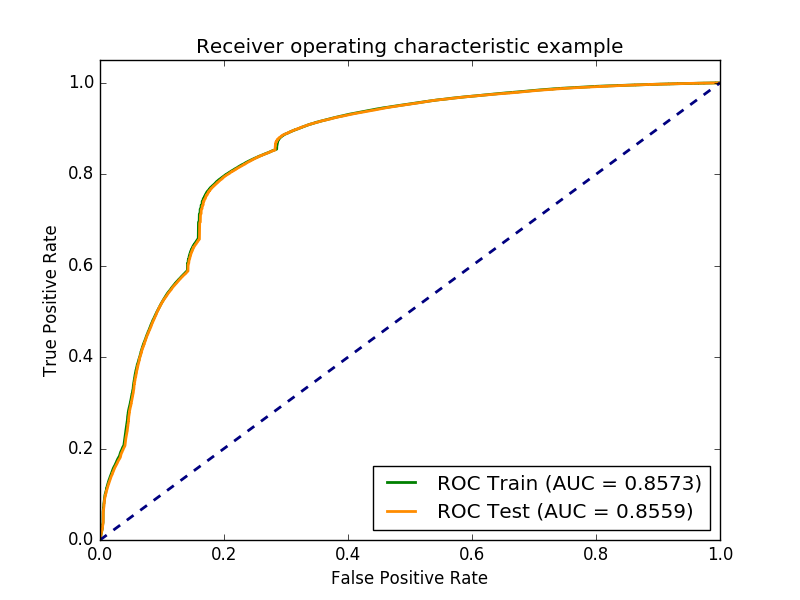

In [24]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Let's train random forest too!

In [26]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=70#50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=13#20 gives overfitted results
                            ,minInstancesPerNode=16
                            ,maxBins=16
                            )
model = ml.fit(train)

In [27]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.15485665910370...| 1.0| 0|(28,[4,9,15,16,18...|
[0.00485033135798...| 1.0| 1|(28,[14,17],[1.0,...|
[0.03295771581901...| 1.0| 1|(28,[4,15,18,19,2...|
[0.10766031803420...| 1.0| 1|(28,[4,9,14,15,16...|
[0.13605239960499...| 1.0| 1|(28,[4,9,14,15,16...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.40148200400908...| 1.0| 0|(28,[1,2,3,4,15,1...|
[0.05087925431458...| 1.0| 1|(28,[4,15,18,19,2...|
[0.55592818603922...| 0.0| 1|(28,[3,4,13,14,15...|
[0.48552946849085...| 1.0| 1|(28,[3,4,15,18,19...|
[0.22965890293798...| 1.0| 0|(28,[4,15,18,19,2...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

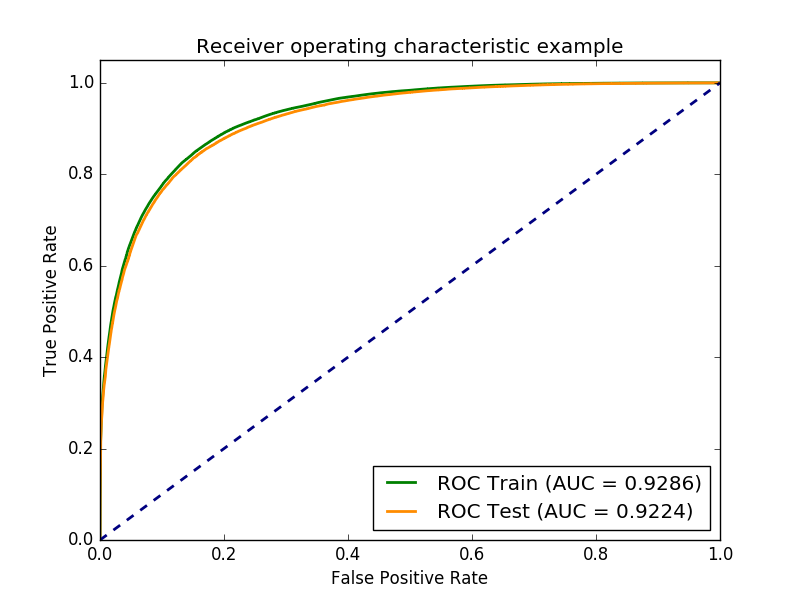

In [28]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

In [29]:
ml_gbt=GBTClassifier(labelCol="label",featuresCol="features",maxIter=100,maxDepth=10,minInstancesPerNode=20,maxBins=16)

In [30]:
model_gbt = ml_gbt.fit(train)

In [31]:
#### predict and evaluate performance

# Predict train data
predictions_train = model_gbt.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model_gbt.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.19291318699747...| 1.0| 0|(28,[4,9,15,16,18...|
[0.01285522886318...| 1.0| 1|(28,[14,17],[1.0,...|
[0.03773452214058...| 1.0| 1|(28,[4,15,18,19,2...|
[0.13341073893320...| 1.0| 1|(28,[4,9,14,15,16...|
[0.15311553829374...| 1.0| 1|(28,[4,9,14,15,16...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
 probability|prediction|label| features|
+--------------------+----------+-----+--------------------+
[0.44482982769293...| 1.0| 0|(28,[1,2,3,4,15,1...|
[0.04729453985762...| 1.0| 1|(28,[4,15,18,19,2...|
[0.58754770128356...| 0.0| 1|(28,[3,4,13,14,15...|
[0.38832595648017...| 1.0| 1|(28,[3,4,15,18,19...|
[0.24847736775461...| 1.0| 0|(28,[4,15,18,19,2...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

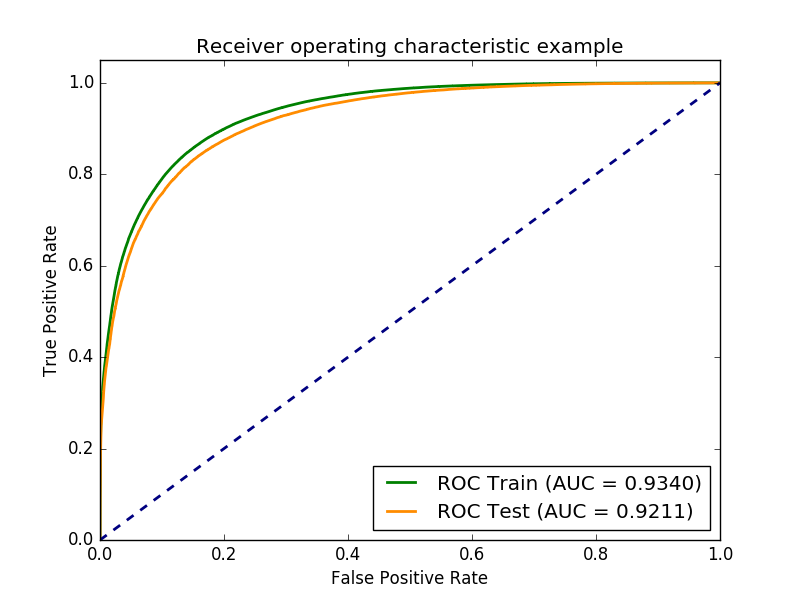

In [32]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)